In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
#import seaborn as sns
#import datetime
#from datetime import datetime, timedelta
import datetime
import re
import scipy.io
from netCDF4 import Dataset
import netCDF4
import sys
import numpy.ma as ma
%matplotlib inline 

In [2]:
import seaborn as sns
sns.set_style('ticks')

In [3]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['figure.figsize'] = (4,3)

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
pcolors_d3 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
#https://github.com/d3/d3-3.x-api-reference/blob/master/Ordinal-Scales.md#category10

In [6]:
center = 'bom'
iso_ecmf_mat = scipy.io.loadmat('/sw19/wangs/s2s_post/olr_20S20N/omi_calc_save_modelversion_9pt/version2/omi_index_' + center +'.mat')
iso_ecmf_mat['iso_fcst'].shape, iso_ecmf_mat['iso_veri'].shape

((2376, 60, 2, 33), (2376, 60, 2))

In [7]:
center_list = [ 'ecmf', 'ncep', 'jma',   'cma', 'cnrm', 'eccc', 'hmcr', 'bom',     'ukmo', 'isac']

In [8]:
def load_calc_acc_phase_lag(center, season = 'all', nens=100, fac=228.82):
    """
    compute anomaly correlation skill at various leads (target)
    """
    if 1 == 11:
        center = 'ecmf'
        #season = 'winter'
    iso_ecmf_mat = scipy.io.loadmat('/sw19/wangs/s2s_post/olr_20S20N/omi_calc_save_modelversion_9pt/version2/omi_index_' + center +'.mat')
    Nfcst, Nt, _, Nens = iso_ecmf_mat['iso_fcst'].shape

    if center == 'ecmf':
        iso_amp_fcst = np.sqrt( iso_ecmf_mat['iso_fcst'][:,:,0,:]**2 + iso_ecmf_mat['iso_fcst'][:,:,1,:]**2  )/fac
        isel = np.arange(iso_ecmf_mat['iso_fcst'].shape[0])
        isel = []
        for ii in np.arange(Nfcst):
            #if (np.sum(iso_ecmf_mat['iso_fcst'][ii,32:]) > 0) and (iso_amp_fcst[ii,32:, 5:].sum(-1).sum(-1) > 0 ) : 
            if  iso_amp_fcst[ii,32:, 5:].sum(-1).sum(-1) > 0 :               
                isel.append(ii)
        isel = np.array(isel)   
        iso_fcst = iso_ecmf_mat['iso_fcst'][isel,:,:,:nens]
        iso_veri = iso_ecmf_mat['iso_veri'][isel,:,:]
        iso_ecmf_mat.update ({'iso_fcst': iso_fcst, 'iso_veri':iso_veri, 'time':iso_ecmf_mat['time'][isel,:]})
        
        
    nens = np.min((Nens, nens))
    
    ini_time = [datetime.datetime.fromordinal(int(tt)) for tt in iso_ecmf_mat['time'][:,0]]
    ini_month = np.array([tt.month for tt in ini_time])
    ini_year = np.array([tt.year for tt in ini_time])

    
    if season == 'all':
        pass
    elif season == 'winter':
        ii = ((ini_month>=12) | (ini_month<=3)) & (ini_year>=1999) & (ini_year<=2010) 
        iso_fcst = iso_ecmf_mat['iso_fcst'][ii,:,:,:nens]
        iso_veri = iso_ecmf_mat['iso_veri'][ii,:,:]
        iso_ecmf_mat.update ({'iso_fcst': iso_fcst, 'iso_veri':iso_veri})
    elif season == 'summer' :
        ii = (ini_month>=6) & (ini_month<=9) & (ini_year>=1999) & (ini_year<=2010) 
        iso_fcst = iso_ecmf_mat['iso_fcst'][ii,:,:,:nens]
        iso_veri = iso_ecmf_mat['iso_veri'][ii,:,:]
        iso_ecmf_mat.update ({'iso_fcst': iso_fcst, 'iso_veri':iso_veri})
        
        

    acc_phase = np.zeros((60, 8))+np.nan
    acc = np.zeros((60))+np.nan
        
    for ilag in np.arange(45) :   
        
        omi_1 = iso_ecmf_mat['iso_veri'][:, ilag, 0]
        omi_2 = iso_ecmf_mat['iso_veri'][:, ilag, 1]
        pha = np.arctan2(-omi_1, omi_2);
        omi_phase = np.floor((pha+np.pi)/(np.pi/4));
        omi_phase += 1



        if 1 == 1:
            i = ilag
  

            ff1 = iso_ecmf_mat['iso_fcst'][:,i,0,:nens].mean(-1)
            ff2 = iso_ecmf_mat['iso_fcst'][:,i,1,:nens].mean(-1)
            vv1 = iso_ecmf_mat['iso_veri'][:,i,0]
            vv2 = iso_ecmf_mat['iso_veri'][:,i,1]

            ff1  = ma.masked_where(np.abs(ff1) >= 1e3, ff1)
            ff2  = ma.masked_where(np.abs(ff2) >= 1e3, ff2)

            num = np.sum(ff1*vv1) + np.sum(ff2*vv2)
            den = np.sqrt(np.sum(ff1**2+ff2**2))*np.sqrt(np.sum(vv1**2+vv2**2))
            acc[i] = num/den

 

            for iphase in np.arange(8):

                isel = (omi_phase == iphase+1)
                #print(iphase, isel.shape)
                ff1 = iso_ecmf_mat['iso_fcst'][isel,i,0,:nens].mean(-1)
                ff2 = iso_ecmf_mat['iso_fcst'][isel,i,1,:nens].mean(-1)
                vv1 = iso_ecmf_mat['iso_veri'][isel,i,0]
                vv2 = iso_ecmf_mat['iso_veri'][isel,i,1]

                if isel.shape[0] < 1:
                    print('wrong isel')
                num = np.sum(ff1*vv1) + np.sum(ff2*vv2)
                den = np.sqrt(np.sum(ff1**2+ff2**2))*np.sqrt(np.sum(vv1**2+vv2**2))
                acc_phase[i,iphase] = num/den
 


    return acc,  acc_phase

In [9]:
acc, acc_phase,  = load_calc_acc_phase_lag('ecmf', season='winter')    

Text(0,0.5,'Anomaly correlation skill')

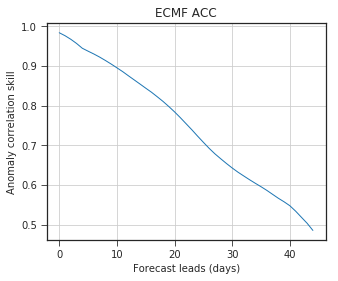

In [10]:
plt.figure(figsize=(5,4))
plt.plot(acc)
plt.title('ECMF ACC')
plt.grid()
plt.xlabel('Forecast leads (days)')
plt.ylabel('Anomaly correlation skill')

In [11]:
center = 'ecmf'

In [12]:
iso_ecmf_mat = scipy.io.loadmat('/sw19/wangs/s2s_post/olr_20S20N/omi_calc_save_modelversion_9pt/version2/omi_index_' + center +'.mat')
ophase = np.zeros((5524, 45))
for ilag in np.arange(40):
    omi_1 = iso_ecmf_mat['iso_veri'][:, ilag, 0]
    omi_2 = iso_ecmf_mat['iso_veri'][:, ilag, 1]
    pha = np.arctan2(-omi_1, omi_2);
    omi_phase = np.floor((pha+np.pi)/(np.pi/4));
    omi_phase += 1
    ophase[:,ilag] = omi_phase

In [13]:
omi_phase.shape, ophase.shape

((5524,), (5524, 45))

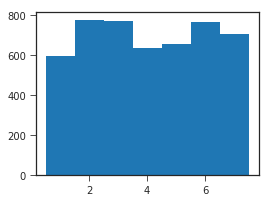

In [14]:
co = plt.hist(ophase[:,2], np.arange(0.5,8.5,1),  )


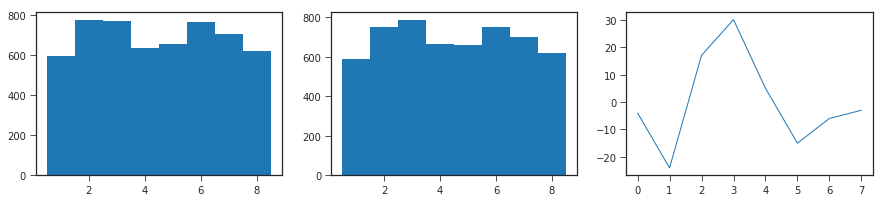

In [15]:
plt.figure(figsize=(15,3))
plt.subplot(131)
co1 = plt.hist(ophase[:,2], np.arange(0.5,9.5,1),  )
#plt.hist(ophase[:,10], np.arange(0.5,8.5,1))

plt.subplot(132)
co2 = plt.hist(ophase[:,20], np.arange(0.5,9.5,1),  )
#plt.hist(ophase[:,10], np.arange(0.5,8.5,1))



plt.subplot(133)
plt.plot(co2[0]- co1[0],  )
#plt.hist(ophase[:,10], np.arange(0.5,8.5,1))

In [16]:
omi_phase.shape, acc_phase.shape

((5524,), (60, 8))

(0, 40)

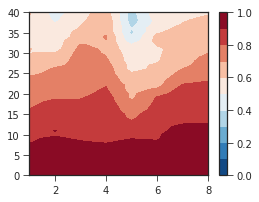

In [17]:
plt.contourf(np.arange(1,9), np.arange(60), acc_phase, cmap='RdBu_r', levels=np.arange(0,1.1,0.1)); plt.colorbar()
plt.ylim([0, 40])

In [18]:
acc_all_lag_win = []
acc_phase_all_lag_win = []

acc_all_lag_sum = []
acc_phase_all_lag_sum = []

acc_all_lag = []
acc_phase_all_lag = []

for i,center in enumerate(center_list):
    acc, acc_phase,  = load_calc_acc_phase_lag(center, season='winter')    
    acc_all_lag_win.append(acc)    
    acc_phase_all_lag_win.append(acc_phase)
    
    acc, acc_phase = load_calc_acc_phase_lag(center, season='summer')    
    acc_all_lag_sum.append(acc)
    acc_phase_all_lag_sum.append(acc_phase)   
    
    acc, acc_phase = load_calc_acc_phase_lag(center, season='all')    
    acc_all_lag.append(acc)
    acc_phase_all_lag.append(acc_phase)  
    print(i, center)

0 ecmf
1 ncep
2 jma
3 cma
4 cnrm
5 eccc
6 hmcr
7 bom
8 ukmo
9 isac


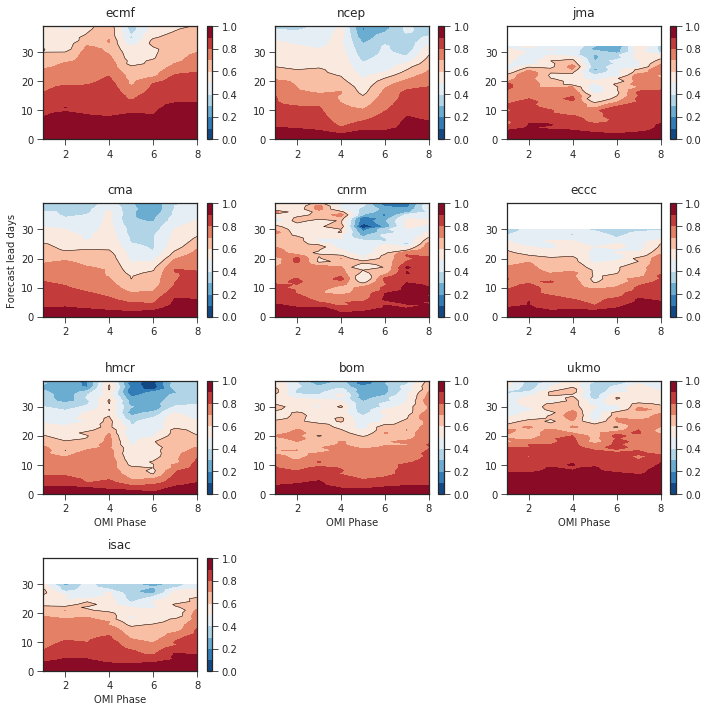

In [19]:
plt.figure(figsize=(10,10))

for i in np.arange(10):
    plt.subplot(4,3,i+1)
    plt.contourf(np.arange(1,9), np.arange(60), acc_phase_all_lag_win[i], cmap='RdBu_r', levels=np.arange(0,1.1,0.1))
    plt.colorbar()
    plt.contour(np.arange(1,9), np.arange(60), acc_phase_all_lag_win[i],   levels=[0.6, 1.5001], colors='k', linewidths=0.5)

    plt.ylim([0,39])
    plt.gca().tick_params(direction='out')
    
    plt.title(center_list[i], y=1.03)
    if i >= 6:
        plt.xlabel('OMI Phase')
    
plt.subplot(4,3,4)
plt.ylabel("Forecast lead days")
plt.tight_layout()    

